In [1]:
from finn.custom_op.registry import getCustomOp
from finn.transformation.base import Transformation
from finn.util.fpgadataflow import is_fpgadataflow_node
from finn.analysis.fpgadataflow.dataflow_performance import dataflow_performance
from finn.transformation.fpgadataflow.annotate_cycles import AnnotateCycles
from finn.transformation.general import GiveUniqueNodeNames
#from finn.transformation.fpgadataflow.set_folding import SetFolding
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from finn.util.fpgadataflow import is_fpgadataflow_node

import matplotlib.pyplot as plt
import random
from copy import deepcopy
import numpy as np

from finn.custom_op.registry import getCustomOp
from finn.transformation.base import Transformation
from finn.util.fpgadataflow import is_fpgadataflow_node
from finn.analysis.fpgadataflow.dataflow_performance import dataflow_performance
from finn.transformation.fpgadataflow.annotate_cycles import AnnotateCycles
from finn.transformation.general import GiveUniqueNodeNames
import warnings

In [2]:
model = ModelWrapper("modelling_estimates_exhaustive/estimate_set_folding_finn_no_pruning_targetfps_2300_1bit_nonpruned/intermediate_models/8_step_hls_codegen.onnx")

In [3]:
graph = model.graph

node = graph.node[15]

In [4]:
node.name # the node we run profiling on

'StreamingFCLayer_Batch_7'

In [5]:
node_inst = getCustomOp(node)

In [6]:
def set_vals_get_est(node, pe=None, simd=None, ret_cycles=None):
    node_inst = getCustomOp(node)
    
    if simd:
        node_inst.set_nodeattr("SIMD", simd)
    if pe:
        node_inst.set_nodeattr("PE", pe)
    
    pe = node_inst.get_nodeattr("PE")
    simd = node_inst.get_nodeattr("SIMD")
    
    luts = node_inst.lut_estimation()
    bram = node_inst.bram_estimation()
    cyc = node_inst.get_exp_cycles()
    
    #print(node.name)
    #print(f"PE: {pe}, SIMD {simd}, LUT estimate {luts}, BRAM estimate {bram}, cycle estimate {cyc}")
    
    if ret_cycles:
        return luts, cyc

In [8]:
#TMEM
512 / 16

32.0

In [9]:
#WMEM
256 * 512 // (16 * 16)

512

In [10]:
set_vals_get_est(node, pe = 1, simd = 1)

In [11]:
# compiled results

luts = [1810,1144,805,797,971,1866,1224,941,1053,1483,1979,1379,1225,1567,2506,2272,1773,1867,2666,4635,2734,2427,3014,4739,8756,3660,3734,5319,8884,16997]
pes = [1, 2, 4, 8, 16, 32, 64]
simds = [ 2, 4, 8, 16, 32]

n = list()
y = list()
x = list()
ests = list()

idx = 0
for p in pes:
    for s in simds:
        est, c = set_vals_get_est(node, p, s, ret_cycles=True)
        if idx < len(luts):
            print(f"SIMD: {s}, PE: {p}, estimate {est}, actual {luts[idx]}, cycles {c}")
            #print((p,s), c, luts[idx])
            n.append((s,p))
            y.append(luts[idx])
            x.append(c)
            ests.append(est)
            idx += 1

SIMD: 2, PE: 1, estimate 432, actual 1810, cycles 131072
SIMD: 4, PE: 1, estimate 445, actual 1144, cycles 65536
SIMD: 8, PE: 1, estimate 471, actual 805, cycles 32768
SIMD: 16, PE: 1, estimate 524, actual 797, cycles 16384
SIMD: 32, PE: 1, estimate 630, actual 971, cycles 8192
SIMD: 2, PE: 2, estimate 467, actual 1866, cycles 65536
SIMD: 4, PE: 2, estimate 493, actual 1224, cycles 32768
SIMD: 8, PE: 2, estimate 546, actual 941, cycles 16384
SIMD: 16, PE: 2, estimate 652, actual 1053, cycles 8192
SIMD: 32, PE: 2, estimate 863, actual 1483, cycles 4096
SIMD: 2, PE: 4, estimate 537, actual 1979, cycles 32768
SIMD: 4, PE: 4, estimate 590, actual 1379, cycles 16384
SIMD: 8, PE: 4, estimate 696, actual 1225, cycles 8192
SIMD: 16, PE: 4, estimate 907, actual 1567, cycles 4096
SIMD: 32, PE: 4, estimate 1329, actual 2506, cycles 2048
SIMD: 2, PE: 8, estimate 678, actual 2272, cycles 16384
SIMD: 4, PE: 8, estimate 784, actual 1773, cycles 8192
SIMD: 8, PE: 8, estimate 995, actual 1867, cycles 4

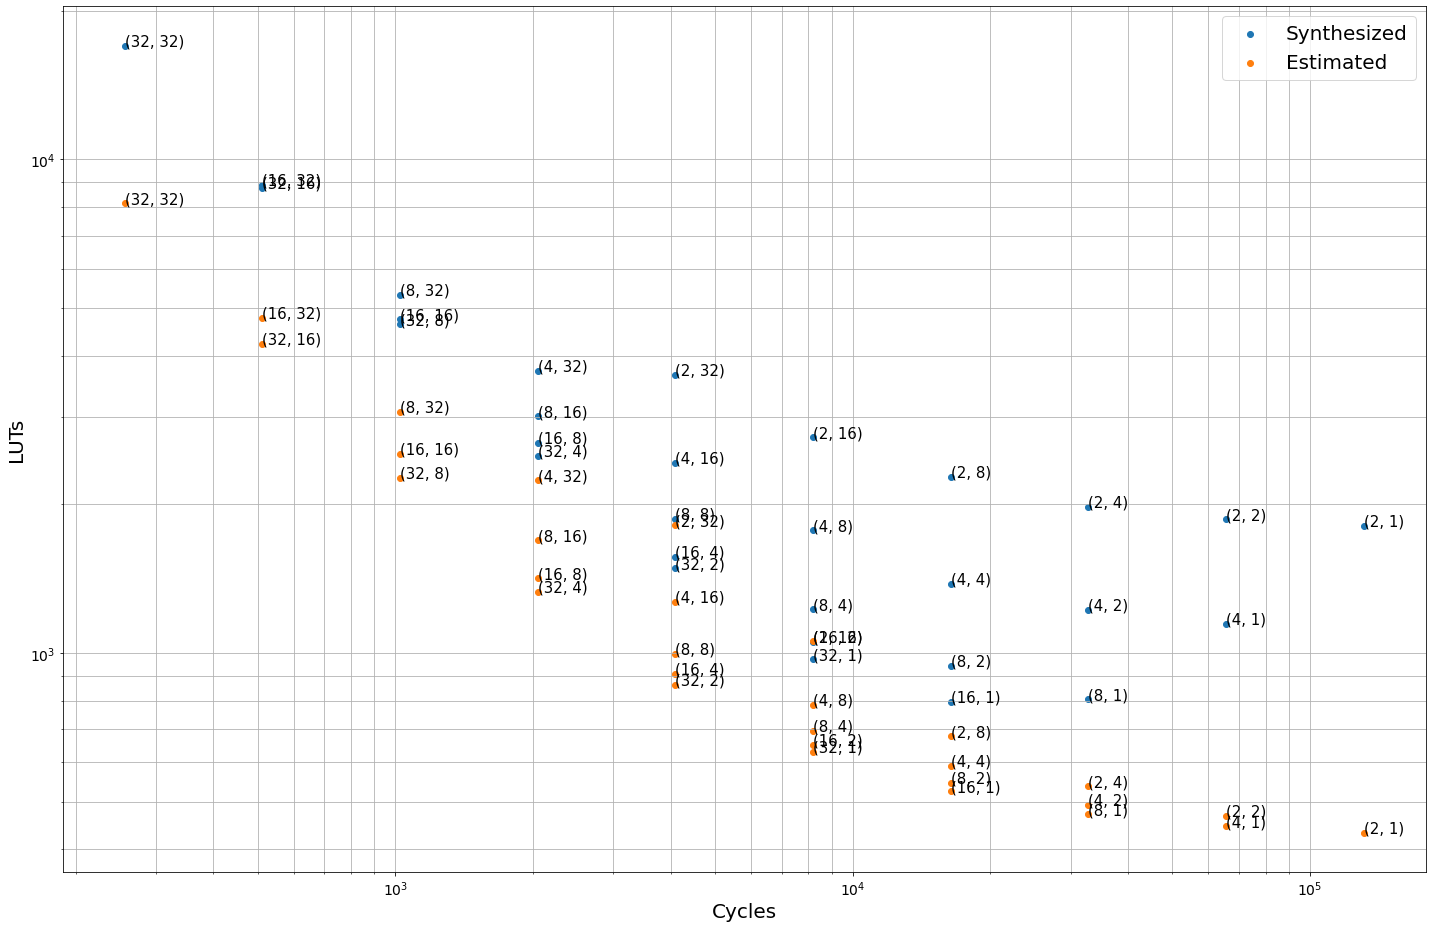

In [18]:
fig, ax = plt.subplots(figsize=(20,13))
plt.rcParams['figure.facecolor'] = 'white'
fig.patch.set_facecolor('white')
#fig.suptitle("LUT usage vs cycle count for varying folding factors within the same layer", fontsize=20)
ax.scatter(x, y, label = "Synthesized")
ax.scatter(x, ests, label = "Estimated")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("LUTs", fontsize=20)
ax.set_xlabel("Cycles", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax.grid(True, which="both")
ax.legend(fontsize=20)
fig.tight_layout()

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]), fontsize=15)
    ax.annotate(txt, (x[i], ests[i]), fontsize=15)

In [20]:
pe_1 = [(2, 1810), (4, 1144), (8, 805), (16, 797), (32, 971), (64, 2723)]
pe_1_est = [(2, 432), (4, 445), (8, 471), (16, 524), (32, 630), (64, 841)]

pe_2 = [(2, 1866), (4, 1224), (8, 941), (16, 1053), (32, 1483), (64, 3719)]
pe_2_est = [(2, 467), (4, 493), (8, 546), (16, 652), (32, 863), (64, 1285)]

pe_4 = [(2, 1979), (4, 1379), (8, 1225), (16, 1567), (32, 2506), (64, 5722)]
pe_4_est = [(2, 537), (4, 590), (8, 696), (16, 907), (32, 1329), (64, 2174)]

pe_8 = [(2, 2272), (4, 1773), (8, 1867), (16, 2666), (32, 4635), (64, 9799)]
pe_8_est = [(2, 678), (4, 784), (8, 995), (16, 1417), (32, 2262), (64, 3952)]

pe_16 = [(2, 2734), (4, 2427), (8, 3014), (16, 4739), (32, 8756), (64, 17816)]
pe_16_est = [(2, 1056), (4, 1268), (8, 1690), (16, 2535), (32, 4224), (64, 7604)]

pe_32 = [(2, 3660), (4, 3734), (8, 5319), (16, 8884), (32, 16997)]
pe_32_est = [(2, 1813), (4, 2236), (8, 3080), (16, 4770), (32, 8149)]


all_vals = [("PE = 1", pe_1, pe_1_est), ("PE = 2", pe_2, pe_2_est), ("PE = 4", pe_4, pe_4_est), ("PE = 8", pe_8, pe_8_est), ("PE = 16", pe_16, pe_16_est), ("PE = 32", pe_32, pe_32_est)]

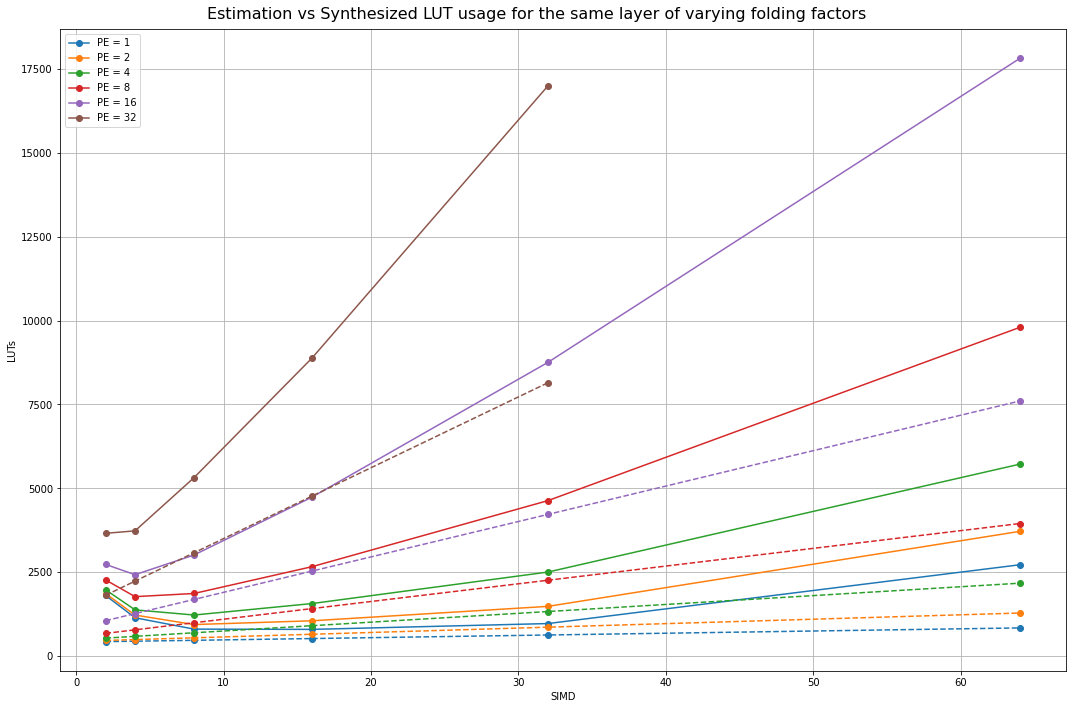

In [21]:
fig = plt.figure(figsize=(15,10))
    
for label, act, est in all_vals:
    p = plt.plot(*zip(*act), 'o-', label = label)

    col = p[0].get_color()
    plt.plot(*zip(*est),'o--', color=col)
#plt.yscale('log')
plt.legend()
plt.suptitle("Estimation vs Synthesized LUT usage for the same layer of varying folding factors", fontsize=16)

plt.xlabel("SIMD")
plt.ylabel("LUTs")
plt.grid()
plt.tight_layout()
plt.show()

### Pareto frontier on results of 2/4 bits


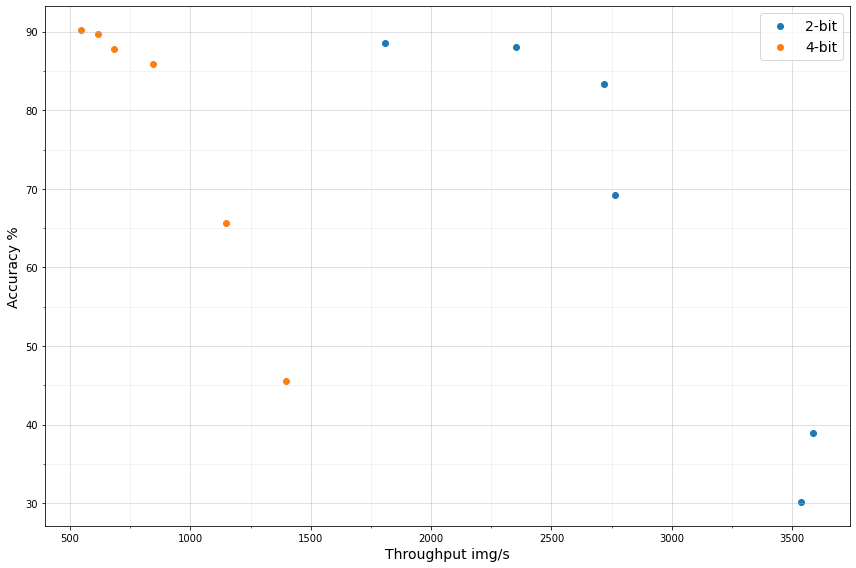

In [22]:
bit_2 = [(1810, 88.62), (2353, 88.02), (2719, 83.35), (2764, 69.2), (3587, 38.88), (3538, 30.12)]

bit_4 = [(547, 90.21), (617, 89.64), (684, 87.79), (845, 85.85), (1149, 65.61), (1399, 45.52)]

fig, ax = plt.subplots(figsize=(12,8))

plt.rcParams['figure.facecolor'] = 'white'
fig.patch.set_facecolor('white')

ax.set_ylabel("Accuracy %", fontsize=14)
ax.set_xlabel("Throughput img/s", fontsize=14)

major_ticks = np.arange(0, 101, 10)
minor_ticks = np.arange(0, 101, 5)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

major_ticks = np.arange(0, 4001, 500)
minor_ticks = np.arange(0, 4001, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)


ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.scatter([i[0] for i in bit_2], [i[1] for i in bit_2], label = "2-bit")
ax.scatter([i[0] for i in bit_4], [i[1] for i in bit_4], label = "4-bit")

ax.legend(fontsize=14)

fig.tight_layout()
plt.show()